In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import uuid
import cvxpy as cp

# Set random seed for reproducibility
np.random.seed(42)

In [75]:
# Step 1: Define System and Simulation Parameters
N = 64  # Number of BS antennas
K = 4   # Number of users
M = 4   # Number of RF chains
omega = 0.3  # Tradeoff weight

I_max = 120  # Maximum outer iterations
sigma_n2 = 1  # Noise variance
mu = 0.01  # Step size for analog precoder
lambda_ = 0.01  # Step size for digital precoder
L = 20  # Number of paths for channel

In [76]:
# Step 2: Define Sensing Parameters
P = 3  # Number of desired sensing angles
theta_d = np.array([-60, 0, 60]) * np.pi / 180  # Desired angles in radians
delta_theta = 5 * np.pi / 180  # Half beamwidth
theta_grid = np.linspace(-np.pi / 2, np.pi / 2, 181)  # Angular grid [-90, 90] degrees
B_d = np.zeros(len(theta_grid))  # Desired beampattern
for t, theta_t in enumerate(theta_grid):
    for theta_p in theta_d:
        if abs(theta_t - theta_p) <= delta_theta:
            B_d[t] = 1

# Wavenumber and antenna spacing
lambda_wave = 1  # Wavelength (normalized)
k = 2 * np.pi / lambda_wave
d = lambda_wave / 2  # Antenna spacing

In [77]:
# Step 3: Channel Matrix Generation (Saleh-Valenzuela Model)
def generate_channel(N, M, L):
    H = np.zeros((M, N), dtype=complex)
    for _ in range(L):
        alpha = np.random.normal(0, 1, 2).view(complex)[0] / np.sqrt(2)  # Complex gain
        phi_r = np.random.uniform(0, 2 * np.pi)  # Angle of arrival
        phi_t = np.random.uniform(0, 2 * np.pi)  # Angle of departure
        a_r = np.exp(1j * k * d * np.arange(M) * np.sin(phi_r)) / np.sqrt(M)
        a_t = np.exp(1j * k * d * np.arange(N) * np.sin(phi_t)) / np.sqrt(N)
        H += np.sqrt(N * M / L) * alpha * np.outer(a_r, a_t.conj())
    return H

# Steering vector function
def steering_vector(theta, N):
    return np.exp(1j * k * d * np.arange(N) * np.sin(theta)) / np.sqrt(N)

# Compute communication rate R
def compute_rate(H, A, D, sigma_n2):
    xi = 1 / np.log(2)
    R = 0
    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)  # (N x 1)
        d_k = D[:, k].reshape(-1, 1)  # (M x 1)

        num = np.abs(h_k.conj().T @ A @ d_k)**2
        denom = sigma_n2 + np.sum([np.abs(h_k.conj().T @ A @ D[:, j].reshape(-1, 1))**2 for j in range(K) if j != k])
        R += xi * np.log2(1 + num / denom)
    return R

# Compute sensing error tau
def compute_tau(A, D, Psi, theta_grid):
    tau = np.linalg.norm(A @ D @ D.conj().T @ A.conj().T - Psi, 'fro')**2
    return tau

def gradient_R_A(H, A, D, sigma_n2):
    xi = 1 / np.log(2)
    grad_A = np.zeros_like(A, dtype=complex)

    # Effective covariance of the digital precoder
    V = D @ D.conj().T

    for k in range(K):
        # User-k effective channel outer product
        h_k = H[k, :].reshape(-1, 1)  # (M x 1)
        H_tilde_k = h_k @ h_k.conj().T

        # D_bar_k = D with user k's column set to zero
        D_bar_k = D.copy()
        D_bar_k[:, k] = 0.0

        V_bar_k = D_bar_k @ D_bar_k.conj().T

        # Denominator terms (trace parts) — fixed
        denom1 = np.trace(A @ V @ A.conj().T @ H_tilde_k) + sigma_n2
        denom2 = np.trace(A @ V_bar_k @ A.conj().T @ H_tilde_k) + sigma_n2

        # Gradient contribution
        term1 = H_tilde_k @ A @ V / denom1
        term2 = H_tilde_k @ A @ V_bar_k / denom2

        grad_A += xi * (term1 - term2)

    return grad_A

def gradient_R_D(H, A, D, sigma_n2):
    xi = 1 / np.log(2)            # Conversion factor from ln() to log2()
    grad_D = np.zeros_like(D, dtype=complex)

    # --- Loop over users k ---
    for k in range(K):
        # (1) Channel vector for user k
        h_k = H[k, :].reshape(-1, 1)             # (N x 1)
        H_tilde_k = h_k @ h_k.conj().T           # (N x N)

        # (2) Effective digital-domain channel including analog precoder
        H_bar_k = A.conj().T @ H_tilde_k @ A     # (M x M)

        # (3) D_bar_k = D with k-th column set to zero
        D_bar_k = D.copy()
        D_bar_k[:, k] = 0.0

        # (4) Compute denominator terms (trace parts)
        denom1 = np.trace(D @ D.conj().T @ H_bar_k) + sigma_n2
        denom2 = np.trace(D_bar_k @ D_bar_k.conj().T @ H_bar_k) + sigma_n2

        # (5) Compute gradient contributions
        term1 = (H_bar_k @ D) / denom1
        term2 = (H_bar_k @ D_bar_k) / denom2

        # (6) Accumulate total gradient
        grad_D += xi * (term1 - term2)

    return grad_D


def gradient_tau_A(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T   # A D Dᴴ Aᴴ
    grad_A = 2 * (U - Psi) @ A @ D @ D.conj().T
    return grad_A


def gradient_tau_D(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T   # A D Dᴴ Aᴴ
    grad_D = 2 * A.conj().T @ (U - Psi) @ A @ D
    return grad_D



In [78]:

# Step 4: Initialization Strategies
def proposed_initialization(H, theta_d, N, M, K, P_BS):
    G = np.array([H[k, :] for k in range(K)]).T  # N x K
    A0 = np.exp(-1j * np.angle(G))[:, :M]
    X_ZF = np.linalg.pinv(H)
    D0 = np.linalg.pinv(A0) @ X_ZF
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def random_initialization(N, M, H, P_BS):
    A0 = np.exp(1j * np.random.uniform(0, 2 * np.pi, (N, M)))
    D0 = np.linalg.pinv(H @ A0)
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def svd_initialization(H, N, M, K, P_BS):
    _, _, Vh = svd(H, full_matrices=False)  # Vh is N x M (conjugate of right singular vectors)
    A0 = Vh.T[:, :M]  # Take first M columns, shape N x M
    A0 = np.exp(1j * np.angle(A0))  # Project to unit modulus
    H_A = H @ A0  # Shape: M x M
    try:
        D0 = np.linalg.pinv(H_A)  # Pseudoinverse of H @ A0
    except np.linalg.LinAlgError:
        D0 = np.linalg.pinv(H_A + 1e-6 * np.eye(M))  # Regularization for stability
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')  # Normalize
    return A0, D0

In [96]:
def run_pga(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, theta_grid, P_BS):
    N, K = H.shape
    A = A0.copy()
    D = D0.copy()
    objectives = []
    eta = 1 / N  # Balancing term for gradient magnitudes

    for i in range(I_max):
        # ---- Inner Loop: Analog Precoder Update ----
        A_hat = A.copy()
        for j in range(J):
            grad_R_A = gradient_R_A(H, A_hat, D, sigma_n2)
            grad_tau_A = gradient_tau_A(A_hat, D, Psi)

            # Eq. (14b): Gradient Ascent on A
            grad_A = grad_R_A - omega * grad_tau_A
            A_hat = A_hat + mu * grad_A

            # Eq. (7): Unit Modulus Projection
            A_hat = np.exp(1j * np.angle(A_hat))

        A = A_hat.copy()  # Set final A after J inner updates

        # ---- Outer Loop: Digital Precoder Update ----
        grad_R_D = gradient_R_D(H, A, D, sigma_n2)
        grad_tau_D = gradient_tau_D(A, D, Psi)

        # Eq. (15): Gradient Ascent on D
        grad_D = grad_R_D - omega * eta * grad_tau_D
        D = D + lambda_ * grad_D

        # Eq. (9): Power Constraint Projection
        D = np.sqrt(P_BS) * D / np.linalg.norm(A @ D, 'fro')

        # ---- Compute Objective (Eq. 5a) ----
        R = compute_rate(H, A, D, sigma_n2)
        # tau = compute_tau(A, D, Psi, theta_grid)
        # objective = R - omega * tau
        # objectives.append(objective)

    return R, A, D


In [80]:
import h5py
SNR_dB_array = np.arange(0, 12.1, 0.1)
# Load Psi data (from MATLAB .mat file)
with h5py.File('Psi_all.mat', 'r') as f:
    Psi_h5 = f['Psi_all']

    # If stored as MATLAB complex structure (real/imag parts separate)
    if np.issubdtype(Psi_h5.dtype, np.void):
        real = Psi_h5['real'][()]
        imag = Psi_h5['imag'][()]
        Psi_all = real + 1j * imag
    else:
        Psi_all = np.array(Psi_h5)

# Ensure Psi_all has shape: (num_SNRs, M, N)
Psi_all = np.squeeze(Psi_all)  # remove singleton dimensions if any


def compute_psi(snr_db):
    """
    Selects the Psi matrix corresponding to the closest SNR value.
    """
    # Find index of closest SNR
    idx = np.argmin(np.abs(SNR_dB_array - snr_db))

    # Select corresponding Psi
    Psi = Psi_all[idx, :, :]

    return Psi


In [90]:
def compute_R_ZF(H, sigma_n2, P_BS):
    """
    Compute the achievable sum rate using Zero-Forcing precoding.
    H: (K x N) channel matrix (K users, N antennas)
    """
    K, N = H.shape

    # Ensure correct orientation (K x N)
    if H.shape[0] != K:
        H = H.T

    # ZF precoder
    X_ZF = H.conj().T @ np.linalg.pinv(H @ H.conj().T)  # (N x K)

    # Normalize total transmit power
    X_ZF = np.sqrt(P_BS) * X_ZF / np.linalg.norm(X_ZF, 'fro')

    # Compute sum rate
    R_ZF = 0.0
    for k in range(K):
        h_k = H[k, :].reshape(1, -1)  # (1 x N)
        signal = np.abs(h_k @ X_ZF[:, k])**2
        interference = np.sum(np.abs(h_k @ X_ZF)**2) - signal
        SINR = signal / (interference + sigma_n2)
        R_ZF += np.log2(1 + SINR)
    return float(np.real(R_ZF))


=== Computing ZF baseline ===
SNR = 0 dB → ZF_Avg R = 13.0062
SNR = 1 dB → ZF_Avg R = 13.8670
SNR = 2 dB → ZF_Avg R = 15.1673
SNR = 3 dB → ZF_Avg R = 15.5399
SNR = 4 dB → ZF_Avg R = 16.7041
SNR = 5 dB → ZF_Avg R = 18.4183
SNR = 6 dB → ZF_Avg R = 20.1648


/tmp/ipykernel_1056069/4249705070.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.real(R_ZF))


SNR = 7 dB → ZF_Avg R = 21.8207
SNR = 8 dB → ZF_Avg R = 22.6816
SNR = 9 dB → ZF_Avg R = 24.0012
SNR = 10 dB → ZF_Avg R = 25.0052
SNR = 11 dB → ZF_Avg R = 26.0165
SNR = 12 dB → ZF_Avg R = 28.0147

=== Running PGA with J = 1 ===


/tmp/ipykernel_1056069/1223431055.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R_PGA_sum += float(R_PGA)


SNR = 0 dB → PGA_Avg R = 3.7166
SNR = 1 dB → PGA_Avg R = 4.1744
SNR = 2 dB → PGA_Avg R = 4.7750
SNR = 3 dB → PGA_Avg R = 4.8990
SNR = 4 dB → PGA_Avg R = 5.9246
SNR = 5 dB → PGA_Avg R = 6.1650
SNR = 6 dB → PGA_Avg R = 6.6015
SNR = 7 dB → PGA_Avg R = 7.2837
SNR = 8 dB → PGA_Avg R = 7.6177
SNR = 9 dB → PGA_Avg R = 8.1939
SNR = 10 dB → PGA_Avg R = 8.7228
SNR = 11 dB → PGA_Avg R = 6.9639
SNR = 12 dB → PGA_Avg R = 5.8337

=== Running PGA with J = 10 ===
SNR = 0 dB → PGA_Avg R = 4.6291
SNR = 1 dB → PGA_Avg R = 5.0385
SNR = 2 dB → PGA_Avg R = 5.3671
SNR = 3 dB → PGA_Avg R = 6.1161
SNR = 4 dB → PGA_Avg R = 6.8684
SNR = 5 dB → PGA_Avg R = 8.3648
SNR = 6 dB → PGA_Avg R = 8.2775
SNR = 7 dB → PGA_Avg R = 10.3573
SNR = 8 dB → PGA_Avg R = 12.6114
SNR = 9 dB → PGA_Avg R = 11.8770
SNR = 10 dB → PGA_Avg R = 9.8413
SNR = 11 dB → PGA_Avg R = 2.3111
SNR = 12 dB → PGA_Avg R = 2.2950


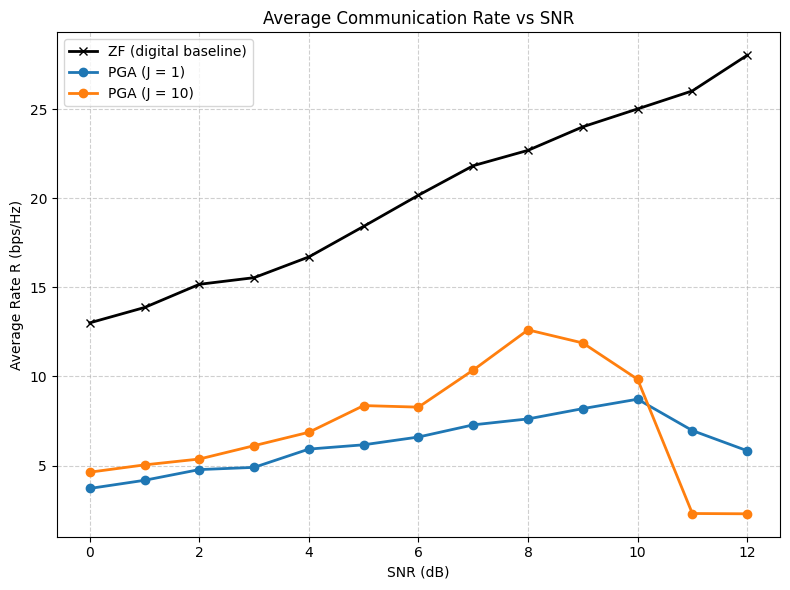

In [109]:
import numpy as np
import matplotlib.pyplot as plt

snr_db_list = list(range(0, 13))
num_realizations = 40
J_values = [1, 10]

R_results = {}
R_ZF_list = []

# --- Compute ZF baseline once ---
print("=== Computing ZF baseline ===")
for snr_db in snr_db_list:
    R_ZF_sum = 0.0
    P_BS = sigma_n2 * 10**(snr_db / 10)

    for realization in range(num_realizations):
        H = generate_channel(N, M, L)
        if H.shape[0] != K:  # ensure (K x N)
            H = H.T
        R_ZF_sum += compute_R_ZF(H, sigma_n2, P_BS)

    R_ZF_avg = R_ZF_sum / num_realizations
    R_ZF_list.append(R_ZF_avg)
    print(f"SNR = {snr_db} dB → ZF_Avg R = {R_ZF_avg:.4f}")

# --- Compute PGA for each J ---
for J in J_values:
    R_PGA_list = []
    print(f"\n=== Running PGA with J = {J} ===")

    for snr_db in snr_db_list:
        R_PGA_sum = 0.0
        P_BS = sigma_n2 * 10**(snr_db / 10)

        for realization in range(num_realizations):
            Psi = compute_psi(snr_db)
            H = generate_channel(N, M, L)
            A0, D0 = proposed_initialization(H, theta_d, N, M, K, P_BS)
            R_PGA, A_opt, D_opt = run_pga(H, A0, D0, J=J, I_max=120, mu=0.01,
                            lambda_=0.01, omega=0.3,
                            sigma_n2=sigma_n2, Psi=Psi,
                            theta_grid=theta_grid, P_BS=P_BS)
            R_PGA_sum += float(R_PGA)

        R_PGA_avg = R_PGA_sum / num_realizations
        R_PGA_list.append(R_PGA_avg)
        print(f"SNR = {snr_db} dB → PGA_Avg R = {R_PGA_avg:.4f}")

    R_results[J] = R_PGA_list

# --- Plot ---
plt.figure(figsize=(8, 6))

# Plot ZF baseline once
plt.plot(snr_db_list, R_ZF_list, marker='x', linewidth=2,
         color='black', label='ZF (digital baseline)')

# Plot PGA results for each J
for J in J_values:
    plt.plot(snr_db_list, R_results[J], marker='o', linewidth=2,
             label=f'PGA (J = {J})')

plt.xlabel('SNR (dB)')
plt.ylabel('Average Rate R (bps/Hz)')
plt.title('Average Communication Rate vs SNR')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== Computing Beampattern MSE for ZF ===


/tmp/ipykernel_1056069/285131870.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"SNR = {snr_db} dB → Avg MSE_ZF = {float(np.real(mse_avg_zf)):.2f} dB")


SNR = 0 dB → Avg MSE_ZF = -7.40 dB
SNR = 1 dB → Avg MSE_ZF = -7.39 dB
SNR = 2 dB → Avg MSE_ZF = -7.42 dB
SNR = 3 dB → Avg MSE_ZF = -7.39 dB
SNR = 4 dB → Avg MSE_ZF = -7.29 dB
SNR = 5 dB → Avg MSE_ZF = -7.45 dB
SNR = 6 dB → Avg MSE_ZF = -7.29 dB
SNR = 7 dB → Avg MSE_ZF = -6.90 dB
SNR = 8 dB → Avg MSE_ZF = -5.48 dB
SNR = 9 dB → Avg MSE_ZF = -3.95 dB
SNR = 10 dB → Avg MSE_ZF = -1.23 dB
SNR = 11 dB → Avg MSE_ZF = 1.05 dB
SNR = 12 dB → Avg MSE_ZF = 5.62 dB

=== Computing Beampattern MSE for PGA (J=1) ===


/tmp/ipykernel_1056069/285131870.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"SNR = {snr_db} dB → Avg MSE_PGA(J={J}) = {float(np.real(mse_avg_pga)):.2f} dB")


SNR = 0 dB → Avg MSE_PGA(J=1) = -7.40 dB
SNR = 1 dB → Avg MSE_PGA(J=1) = -7.36 dB
SNR = 2 dB → Avg MSE_PGA(J=1) = -7.39 dB
SNR = 3 dB → Avg MSE_PGA(J=1) = -7.40 dB
SNR = 4 dB → Avg MSE_PGA(J=1) = -7.38 dB
SNR = 5 dB → Avg MSE_PGA(J=1) = -7.10 dB
SNR = 6 dB → Avg MSE_PGA(J=1) = -6.86 dB
SNR = 7 dB → Avg MSE_PGA(J=1) = -6.58 dB
SNR = 8 dB → Avg MSE_PGA(J=1) = -6.34 dB
SNR = 9 dB → Avg MSE_PGA(J=1) = -4.41 dB
SNR = 10 dB → Avg MSE_PGA(J=1) = -2.91 dB
SNR = 11 dB → Avg MSE_PGA(J=1) = -3.23 dB
SNR = 12 dB → Avg MSE_PGA(J=1) = 1.21 dB

=== Computing Beampattern MSE for PGA (J=10) ===
SNR = 0 dB → Avg MSE_PGA(J=10) = -7.39 dB
SNR = 1 dB → Avg MSE_PGA(J=10) = -7.40 dB
SNR = 2 dB → Avg MSE_PGA(J=10) = -7.30 dB
SNR = 3 dB → Avg MSE_PGA(J=10) = -7.32 dB
SNR = 4 dB → Avg MSE_PGA(J=10) = -7.28 dB
SNR = 5 dB → Avg MSE_PGA(J=10) = -6.88 dB
SNR = 6 dB → Avg MSE_PGA(J=10) = -6.98 dB
SNR = 7 dB → Avg MSE_PGA(J=10) = -5.88 dB
SNR = 8 dB → Avg MSE_PGA(J=10) = -6.24 dB
SNR = 9 dB → Avg MSE_PGA(J=10) = -4.7

ValueError: x and y can be no greater than 2D, but have shapes (13,) and (13, 1, 1)

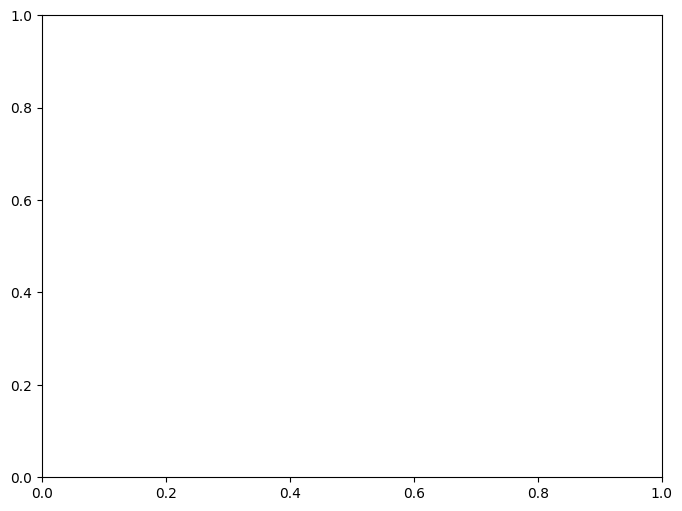

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Helper Functions ===

def steering_vector(theta_deg, N):
    """Compute the normalized steering vector for a ULA."""
    theta_rad = np.deg2rad(theta_deg)
    n = np.arange(N)
    return (1 / np.sqrt(N)) * np.exp(1j * np.pi * n * np.sin(theta_rad))

def desired_beampattern(theta_grid, target_angles, width=5):
    """Desired beampattern: 1 within ±width° of target angles, else 0."""
    B_d = np.zeros_like(theta_grid, dtype=float)
    for t in target_angles:
        B_d[np.abs(theta_grid - t) <= width] = 1.0
    return B_d

def compute_beampattern_MSE(A, D, Psi, theta_grid, B_d):
    """Compute the average radar beampattern MSE."""
    N = A.shape[0]
    Psi_AD = A @ D @ D.conj().T @ A.conj().T  # Realized covariance
    T = len(theta_grid)
    mse = 0.0
    for theta in theta_grid:
        a_t = steering_vector(theta, N).reshape(-1, 1)
        B_realized = np.abs(a_t.conj().T @ Psi_AD @ a_t)**2
        mse += np.abs(B_d[theta_grid == theta] - B_realized)**2
    mse /= T
    mse_db = 10 * np.log10(np.real(mse) + 1e-12)  # avoid log(0)
    return mse_db

def compute_beampattern_MSE_ZF(H, sigma_n2, P_BS, theta_grid, B_d):
    """Compute MSE for Zero-Forcing precoder."""
    N = H.shape[1]
    X_ZF = H.conj().T @ np.linalg.pinv(H @ H.conj().T)
    X_ZF = np.sqrt(P_BS) * X_ZF / np.linalg.norm(X_ZF, 'fro')
    Psi_ZF = X_ZF @ X_ZF.conj().T
    T = len(theta_grid)
    mse = 0.0
    for theta in theta_grid:
        a_t = steering_vector(theta, N).reshape(-1, 1)
        B_realized = np.abs(a_t.conj().T @ Psi_ZF @ a_t)**2
        mse += np.abs(B_d[theta_grid == theta] - B_realized)**2
    mse /= T
    mse_db = 10 * np.log10(np.real(mse) + 1e-12)
    return mse_db

# === Simulation Parameters ===

snr_db_list = list(range(0, 13))
num_realizations = 20
theta_grid = np.linspace(-90, 90, 181)
theta_d = np.array([-60, 0, 60])
B_d = desired_beampattern(theta_grid, theta_d)
J_values = [1, 10]  # J values for PGA
sigma_n2 = 1

# === Containers for results ===
MSE_results_PGA = {J: [] for J in J_values}
MSE_results_ZF = []

# === Compute ZF MSE once per SNR ===
print("=== Computing Beampattern MSE for ZF ===")
for snr_db in snr_db_list:
    P_BS = sigma_n2 * 10**(snr_db / 10)
    mse_sum_zf = 0.0
    for realization in range(num_realizations):
        H = generate_channel(N, M, L)
        mse_sum_zf += compute_beampattern_MSE_ZF(H, sigma_n2, P_BS, theta_grid, B_d)
    mse_avg_zf = mse_sum_zf / num_realizations
    MSE_results_ZF.append(mse_avg_zf)
    print(f"SNR = {snr_db} dB → Avg MSE_ZF = {float(np.real(mse_avg_zf)):.2f} dB")


# === Compute PGA MSE for each J ===
for J in J_values:
    print(f"\n=== Computing Beampattern MSE for PGA (J={J}) ===")
    for snr_db in snr_db_list:
        P_BS = sigma_n2 * 10**(snr_db / 10)
        mse_sum_pga = 0.0
        for realization in range(num_realizations):
            Psi = compute_psi(snr_db)
            H = generate_channel(N, M, L)
            A, D = proposed_initialization(H, theta_d, N, M, K, P_BS)
            R, A_opt, D_opt = run_pga(H, A, D, J=J, I_max=120, mu=0.01,
                                   lambda_=0.01, omega=0.3, sigma_n2=sigma_n2,
                                   Psi=Psi, theta_grid=theta_grid, P_BS=P_BS)  # ensure run_pga returns A,D
            mse_sum_pga += compute_beampattern_MSE(A_opt, D_opt, Psi, theta_grid, B_d)
        mse_avg_pga = mse_sum_pga / num_realizations
        MSE_results_PGA[J].append(mse_avg_pga)
        print(f"SNR = {snr_db} dB → Avg MSE_PGA(J={J}) = {float(np.real(mse_avg_pga)):.2f} dB")




/tmp/ipykernel_1056069/17146095.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MSE_results_ZF = [float(np.real(x)) if isinstance(x, np.ndarray) else float(x) for x in MSE_results_ZF]
/tmp/ipykernel_1056069/17146095.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MSE_results_PGA[J] = [float(np.real(x)) if isinstance(x, np.ndarray) else float(x) for x in MSE_results_PGA[J]]


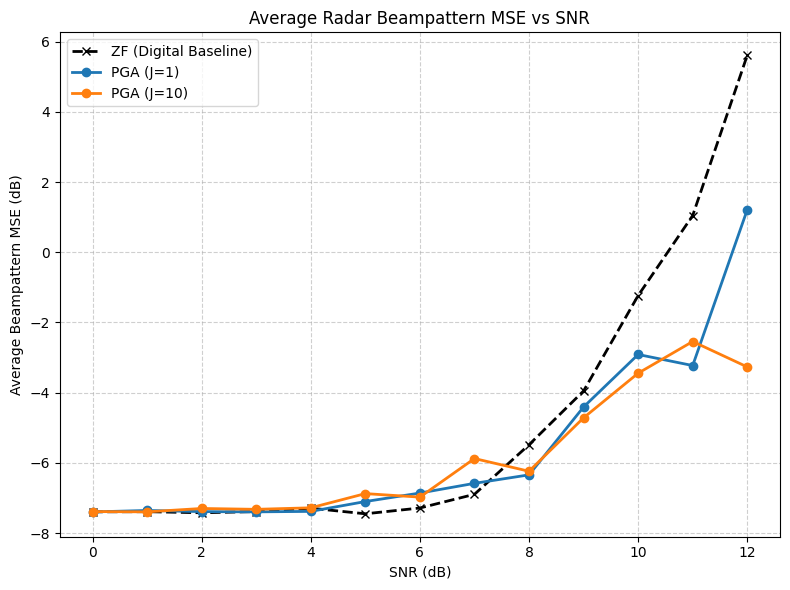

In [108]:
# Convert ZF MSE to float scalars
MSE_results_ZF = [float(np.real(x)) if isinstance(x, np.ndarray) else float(x) for x in MSE_results_ZF]

# Convert PGA MSE to float scalars
for J in J_values:
    MSE_results_PGA[J] = [float(np.real(x)) if isinstance(x, np.ndarray) else float(x) for x in MSE_results_PGA[J]]

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(snr_db_list, MSE_results_ZF, 'k--', marker='x', linewidth=2, label='ZF (Digital Baseline)')
for J in J_values:
    plt.plot(snr_db_list, MSE_results_PGA[J], marker='o', linewidth=2, label=f'PGA (J={J})')

plt.xlabel('SNR (dB)')
plt.ylabel('Average Beampattern MSE (dB)')
plt.title('Average Radar Beampattern MSE vs SNR')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
